In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import h5py
import pystan
import scipy.linalg as sl
import scipy.signal as sig
import seaborn as sns
import qnm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

INFO:root:Could not load Schw QNM dict from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/schwarzschild/data/Schw_dict.pickle


In [3]:
with h5py.File('H-H1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Hstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Hts = linspace(T0, T0+32-1.0/4096, Hstrain.shape[0])

with h5py.File('L-L1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Lstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Lts = linspace(T0, T0+32-1/4096, Lstrain.shape[0])
    
fny = 1.0/(Hts[1]-Hts[0])/2.0

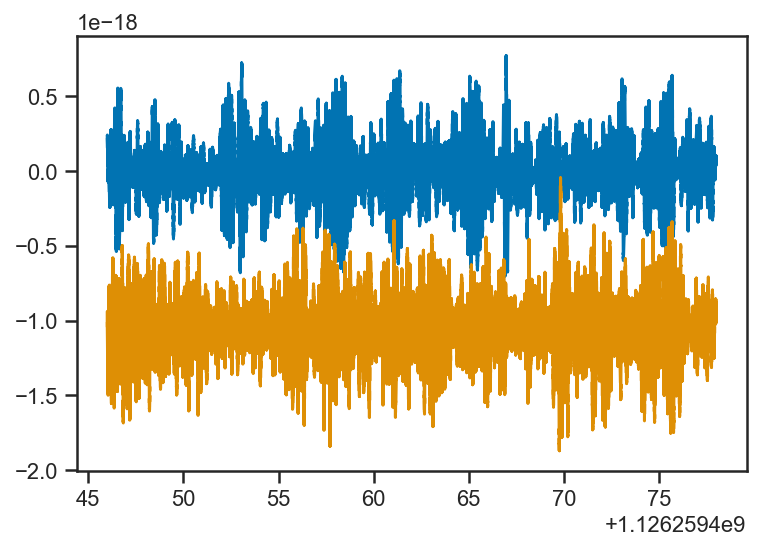

In [4]:
plot(Hts, Hstrain, label='H')
plot(Lts, Lstrain, label='L')

In [28]:
b, a = sig.butter(4, [32/fny, 1024/fny], btype='bandpass', output='ba')
Hfilt = sig.filtfilt(b, a, Hstrain)[::2]
Lfilt = sig.filtfilt(b, a, Lstrain)[::2]
Htsfilt = Hts[::2]
Ltsfilt = Lts[::2]

I0H = argmin(abs(1126259462.423-Htsfilt))
T0H = Htsfilt[I0H]
I0L = argmin(abs(1126259462.423-7e-3-Ltsfilt))
T0L = Ltsfilt[I0L]
Nanalyze = 128
Tanalyze = Nanalyze*(Htsfilt[1]-Htsfilt[0])
print('Will analyze {:.3f} s of data'.format(Tanalyze))

Will analyze 0.062 s of data


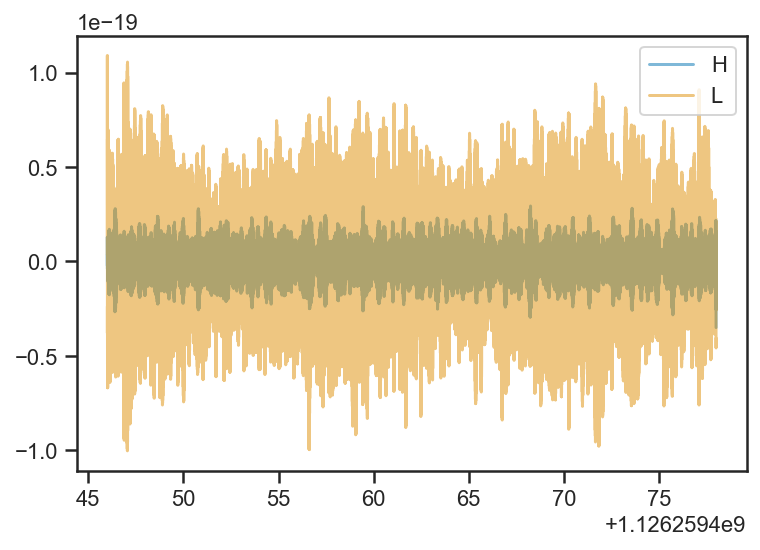

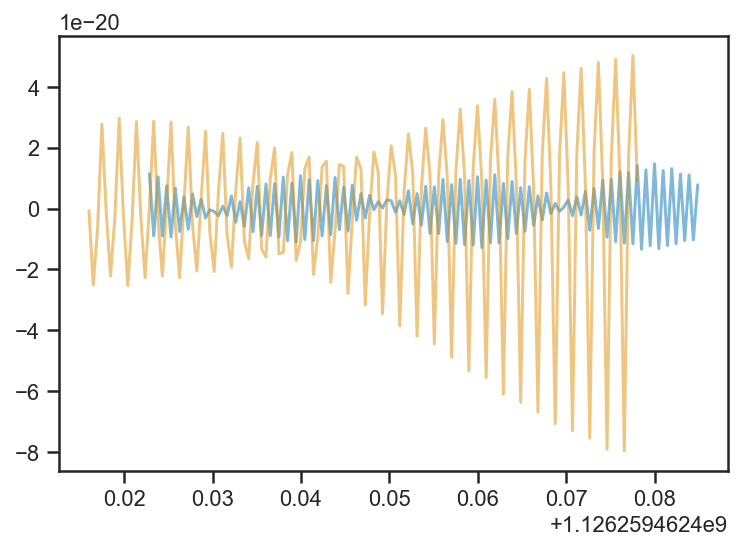

In [29]:
plot(Htsfilt, Hfilt, label='H', alpha=0.5)
plot(Ltsfilt, Lfilt, label='L', alpha=0.5)

legend(loc='best')

figure()
plot(Htsfilt[I0H:I0H+Nanalyze], Hfilt[I0H:I0H+Nanalyze], label='H', alpha=0.5)
plot(Ltsfilt[I0L:I0L+Nanalyze], Lfilt[I0L:I0L+Nanalyze], label='L', alpha=0.5)

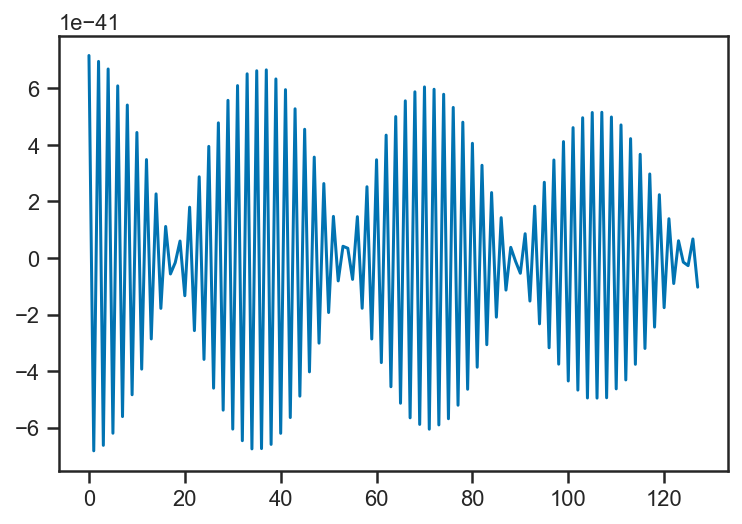

In [30]:
Hrho = sig.correlate(Hfilt, Hfilt)/Hfilt.shape[0]
Hrho = ifftshift(Hrho)
plot(Hrho[:Nanalyze])

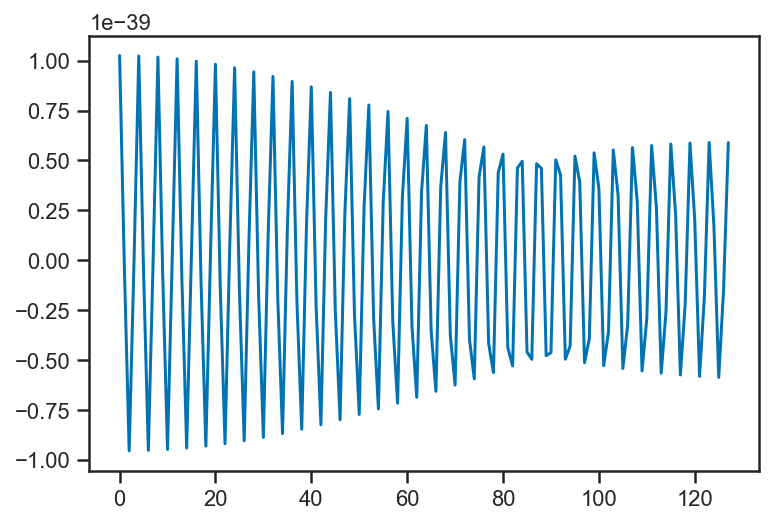

In [31]:
Lrho = sig.correlate(Lfilt, Lfilt)/Lfilt.shape[0]
Lrho = ifftshift(Lrho)
plot(Lrho[:Nanalyze])

In [32]:
HC = sl.toeplitz(Hrho[:Nanalyze])
HL = np.linalg.cholesky(HC)

LC = sl.toeplitz(Lrho[:Nanalyze])
LL = np.linalg.cholesky(LC)

This is something like the GW150914 plot: whitened data, with L shifted and inverted.

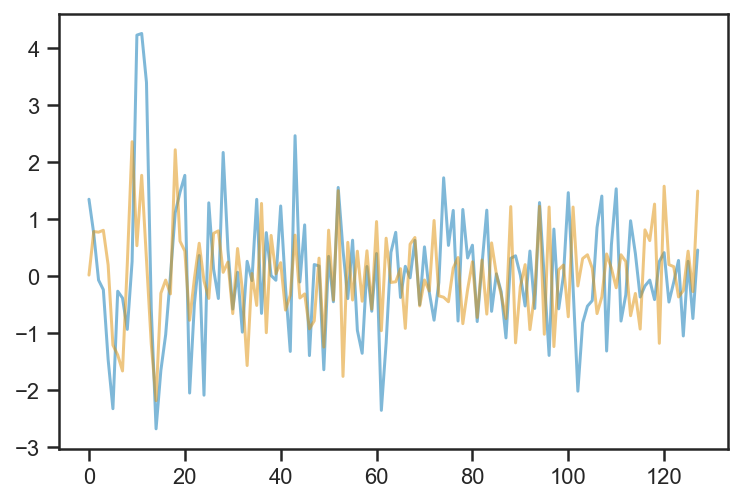

In [35]:
plot(np.linalg.solve(HL, Hfilt[I0H:I0H+Nanalyze]), label='H', alpha=0.5)
plot(-np.linalg.solve(LL, Lfilt[I0L:I0L+Nanalyze]), label='L', alpha=0.5)

In [36]:
x = randn(Nanalyze)
bHc = sl.cho_solve((HL, True), x)
bHt = sl.solve_toeplitz(Hrho[:Nanalyze], x)

In [37]:
x = randn(Nanalyze)
bLc = sl.cho_solve((LL, True), x)
bLt = sl.solve_toeplitz(Lrho[:Nanalyze], x)

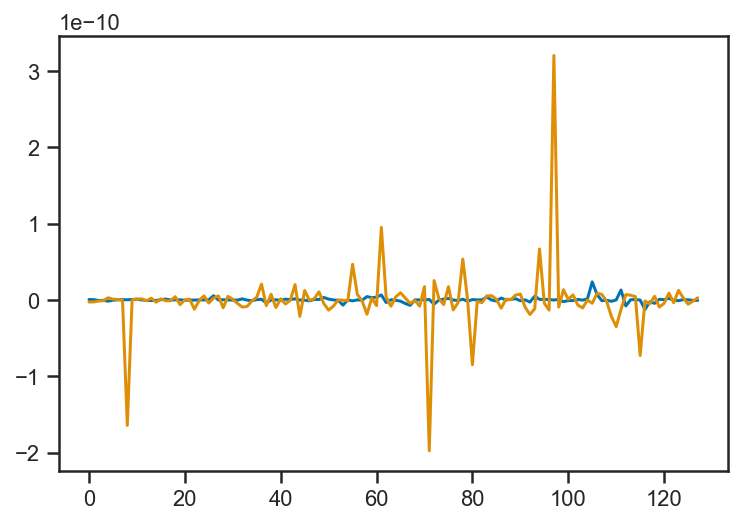

In [38]:
plot(2.0*(bHc-bHt)/(np.abs(bHc) + np.abs(bHt)))
plot(2.0*(bLc-bLt)/(np.abs(bLc) + np.abs(bLt)))

In [39]:
fref = 2.98e3 # Hz, at 68 MSun
chi0 = 0.69

g220 = qnm.modes_cache(-2, 2, 2, 0)
omega, _, _ = g220(a=chi0)
f0 = real(omega)/(2*pi) * fref
tau0 = abs(imag(omega)) * fref

g221 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g221(a=chi0)
f1 = real(omega)/(2*pi) * fref
tau1 = abs(imag(omega)) * fref

print('Given estimated tau0, expect signal to be down by exp(-{:.1f}) by end of data'.format(tau0*Tanalyze))

Given estimated tau0, expect signal to be down by exp(-15.1) by end of data


In [52]:
model = pystan.StanModel(file='ringdown.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4b03469b658c865182d6b1249236ef9f NOW.
/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpvc7w0kop/stanfit4anon_model_4b03469b658c865182d6b1249236ef9f_6352785677694683835.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [68]:
data = {
    'nobs': 2,
    'nsamp': Nanalyze,
    'nmode': 2,
    
    'ts': (Htsfilt[I0H:I0H+Nanalyze] - Htsfilt[I0H],)*2,
    'strain': [Hfilt[I0H:I0H+Nanalyze], Lfilt[I0L:I0L+Nanalyze]],
    'L': [HL, LL],
    
    'mu_logf': [log(f0), log(f1)],
    'sigma_logf': [0.1, 0.1],
    
    'mu_logtau': [log(tau0), log(tau1)],
    'sigma_logtau': [0.1, 0.1],
    
    'Amax': 1e-19
}

In [ ]:
fit = model.sampling(data=data, iter=4000, thin=2)

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [60]:
fit = az.convert_to_inference_data(fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e319f60>,
      dtype=object)

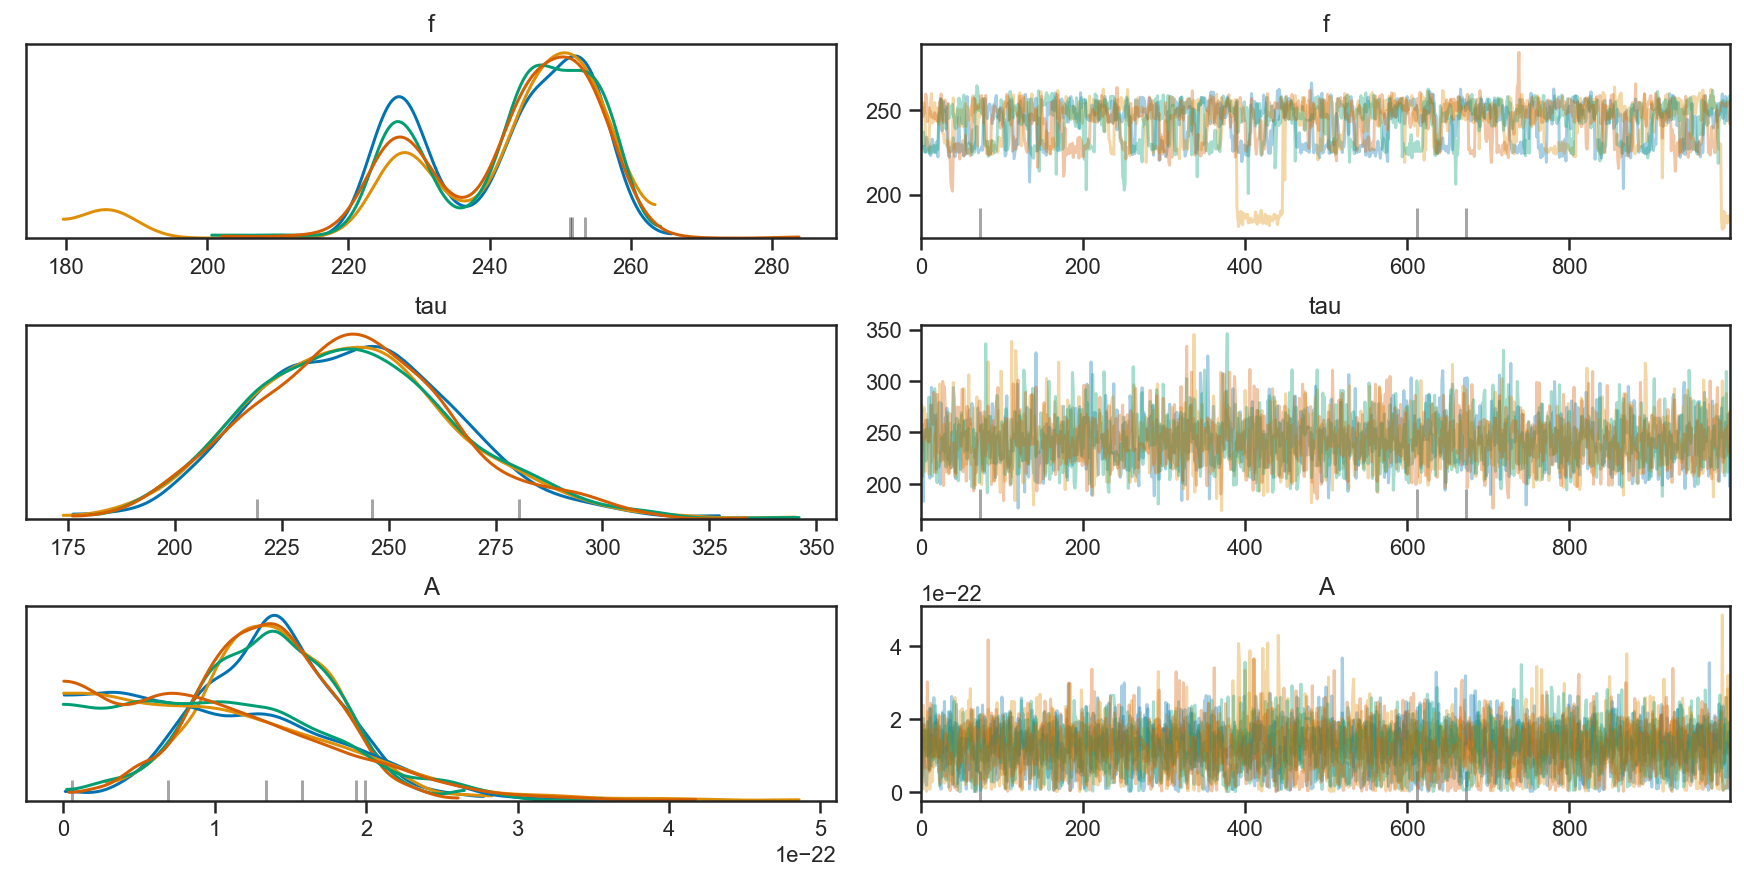

In [61]:
az.plot_trace(fit, var_names=['f', 'tau', 'A', 'phi'], compact=True)

In [64]:
mean(fit.posterior.f.values), std(fit.posterior.f.values), f0

(242.29126299283877, 13.557448340732224, 250.52546857717263)

In [67]:
std(log(fit.posterior.f.values)), std(log(fit.posterior.tau.values))

(0.05872912188106088, 0.0990111869867408)